<h2>Importing Modules</h2>

In [2]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from pprint import pprint
import pyLDAvis.gensim
import pickle 
import pyLDAvis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2>Loading Data</h2>

In [3]:
os.chdir('..')
train = pd.read_csv("D:\\DEVELOPEMENT\\Kaggle Contest\\AES-Kaggle\\Main\\input_data\\train.csv")

train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3


<h2>Data Cleaning</h2>

In [4]:
train = train.drop(columns=["essay_id"], axis=1)
train.head()

,full_text,score
0,Many people have car where they live. The thin...,3
1,I am a scientist at NASA that is discussing th...,3
2,People always wish they had the same technolog...,4
3,"We all heard about Venus, the planet without a...",4
4,"Dear, State Senator\r\n\r\nThis is a letter to...",3


In [5]:
train['full_text_processed'] = train['full_text'].map(lambda x: re.sub('[,\.!?]', '', x))
train['full_text_processed']=train['full_text_processed'].map(lambda x: x.lower())

train['full_text_processed'].head()



<>:1: DeprecationWarning: invalid escape sequence '\.'
<>:1: DeprecationWarning: invalid escape sequence '\.'
C:\Users\HP\AppData\Local\Temp\ipykernel_14656\1779158354.py:1: DeprecationWarning: invalid escape sequence '\.'
  train['full_text_processed'] = train['full_text'].map(lambda x: re.sub('[,\.!?]', '', x))


0    many people have car where they live the thing...
1    i am a scientist at nasa that is discussing th...
2    people always wish they had the same technolog...
3    we all heard about venus the planet without al...
4    dear state senator\r\n\r\nthis is a letter to ...
Name: full_text_processed, dtype: object

<h2>Exploratory Analysis</h2>

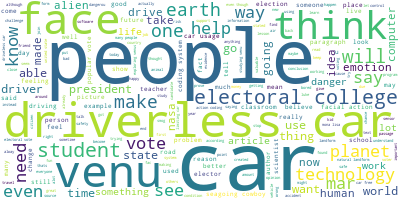

In [6]:
long_string = ','.join(list(train['full_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

<h2>Preparing data for LDA analysis</h2>

In [7]:
stop_words = stopwords.words('english')
# we need to add some more stopwords =>
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    # function to convert sentences to words
    # deacc removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    # Function to stop stopwords
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = train.full_text_processed.values.tolist()

data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['many', 'people', 'car', 'live', 'thing', 'know', 'car', 'alot', 'thing', 'happen', 'like', 'get', 'accidet', 'smoke', 'car', 'bad', 'breath', 'someone', 'walk', 'vaubangermany', 'dont', 'proble', 'percent', 'vauban', 'families', 'carsand', 'percent', 'sold', 'car', 'move']


In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
# Each tuple represents a word in the document along with its frequency.
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 14), (23, 3), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


<h3>LDA model training</h3>

In [9]:
# Number of topics = 10
num_topics = 5

# Build LDA Model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"cars" + 0.019*"car" + 0.013*"would" + 0.010*"people" + '
  '0.008*"driverless" + 0.008*"like" + 0.007*"could" + 0.007*"one" + '
  '0.006*"even" + 0.006*"venus"'),
 (1,
  '0.015*"venus" + 0.014*"cars" + 0.011*"would" + 0.011*"car" + 0.008*"people" '
  '+ 0.007*"also" + 0.007*"could" + 0.007*"like" + 0.006*"even" + '
  '0.006*"driverless"'),
 (2,
  '0.013*"could" + 0.012*"people" + 0.012*"face" + 0.011*"cars" + '
  '0.010*"would" + 0.009*"electoral" + 0.007*"mars" + 0.007*"even" + '
  '0.007*"venus" + 0.007*"college"'),
 (3,
  '0.018*"venus" + 0.015*"cars" + 0.014*"would" + 0.011*"car" + 0.010*"people" '
  '+ 0.010*"could" + 0.008*"like" + 0.007*"planet" + 0.007*"driverless" + '
  '0.007*"also"'),
 (4,
  '0.018*"would" + 0.017*"people" + 0.015*"car" + 0.010*"cars" + 0.009*"like" '
  '+ 0.009*"could" + 0.008*"also" + 0.007*"venus" + 0.006*"electoral" + '
  '0.006*"think"')]


<h3>Analyzing LDA model results</h3>

In [10]:
# Visualize the topics
pyLDAvis.enable_notebook()

file_name = str(num_topics) +'.html'
LDAvis_data_filepath = os.path.join('D:\\DEVELOPEMENT\\Kaggle Contest\\AES-Kaggle\\Main\\topic_evaluation\\result_data\\ldavis_prepared_' + str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'D:\\DEVELOPEMENT\\Kaggle Contest\\AES-Kaggle\\Main\\topic_evaluation\\result_data\\ldavis_prepared_'+ file_name)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.016627  0.008204       1        1  31.817299
4      0.002759  0.003567       2        1  21.913578
3      0.002088 -0.010755       3        1  19.417921
2      0.016549  0.006763       4        1  19.117900
1     -0.004769 -0.007779       5        1   7.733300, topic_info=          Term          Freq         Total Category  logprob  loglift
498      venus  29608.000000  29608.000000  Default  30.0000  30.0000
23        cars  48038.000000  48038.000000  Default  29.0000  29.0000
238      would  42457.000000  42457.000000  Default  28.0000  28.0000
163       also  18816.000000  18816.000000  Default  27.0000  27.0000
171      could  28740.000000  28740.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
158        way    872.477643  11977.947310   Topic5  -5.6384  -0.0599
180       face   1052.605676  19353.036154   Topic5  -5.4507  -0.3519
121        see    802.944520  10570.849977   Topic5  -5.7214  -0.0179
185      human    812.902181  11486.010750   Topic5  -5.7091  -0.0886
532  electoral    830.507567  17021.874848   Topic5  -5.6877  -0.4606

[492 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
239       1  0.272390   able
239       2  0.305285   able
239       3  0.180986   able
239       4  0.163954   able
239       5  0.077491   able
...     ...       ...    ...
2963      1  0.540514  zones
2963      2  0.164962  zones
2963      3  0.089501  zones
2963      4  0.147413  zones
2963      5  0.057912  zones

[1317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 3, 2])

<h2>Feature Engineering</h2>

In [11]:
topic_list = lda_model.top_topics(corpus=corpus)
pprint(topic_list[0][0])

[(0.017825788, 'venus'),
 (0.014940659, 'cars'),
 (0.013538108, 'would'),
 (0.011033949, 'car'),
 (0.010279659, 'people'),
 (0.009783518, 'could'),
 (0.008217017, 'like'),
 (0.007354256, 'planet'),
 (0.0070852293, 'driverless'),
 (0.007079242, 'also'),
 (0.0061396966, 'many'),
 (0.005961103, 'get'),
 (0.005833498, 'make'),
 (0.0058111353, 'one'),
 (0.0055494173, 'earth'),
 (0.005304405, 'face'),
 (0.0052109086, 'help'),
 (0.0050695, 'new'),
 (0.005026174, 'author'),
 (0.0049393405, 'technology')]


In [12]:
# pprint(data_words)
relevance_train = pd.DataFrame(columns=['relevancy', 'score'])
relevance_train['score'] = train['score']
relevancy = []
for new_document in data:
    new_bow = lda_model.id2word.doc2bow(new_document.lower().split())
    doc_topics = lda_model.get_document_topics(new_bow, per_word_topics=False)

    most_relevant_topic = max(doc_topics, key=lambda x: x[1])
    relevancy.append(most_relevant_topic[1])

# print(relevancy)
relevance_train['relevancy'] = relevancy


In [15]:
relevance_train.head(30)

,relevancy,score
0,0.996254,3
1,0.938063,3
2,0.795004,4
3,0.828105,4
4,0.995256,3
5,0.688648,4
6,0.624970,2
7,0.923172,3
8,0.729202,2
9,0.926203,3


<h2>Exporting relevance_train</h2>

In [14]:
relevance_train.to_csv("D:\\DEVELOPEMENT\\Kaggle Contest\\AES-Kaggle\\Main\\int_data\\relevance_train.csv")